使用设备：cuda
共加载 5616 张图片，共 3 个类别。
训练集：3369，验证集：1123，测试集：1124
Epoch [1/100] | Train Loss: 1.0518 | Train Acc: 0.4470 | Val Loss: 0.9868 | Val Acc: 0.5165
保存最佳模型到: L:\常惠林\code\result\best2_resnet50.pth
Epoch [2/100] | Train Loss: 0.9085 | Train Acc: 0.5782 | Val Loss: 0.8586 | Val Acc: 0.5859
保存最佳模型到: L:\常惠林\code\result\best2_resnet50.pth
Epoch [3/100] | Train Loss: 0.7948 | Train Acc: 0.6302 | Val Loss: 0.7688 | Val Acc: 0.6385
保存最佳模型到: L:\常惠林\code\result\best2_resnet50.pth
Epoch [4/100] | Train Loss: 0.7116 | Train Acc: 0.6702 | Val Loss: 0.7107 | Val Acc: 0.6696
保存最佳模型到: L:\常惠林\code\result\best2_resnet50.pth
Epoch [5/100] | Train Loss: 0.6569 | Train Acc: 0.7014 | Val Loss: 0.6678 | Val Acc: 0.6866
保存最佳模型到: L:\常惠林\code\result\best2_resnet50.pth
Epoch [6/100] | Train Loss: 0.5939 | Train Acc: 0.7412 | Val Loss: 0.6143 | Val Acc: 0.7204
保存最佳模型到: L:\常惠林\code\result\best2_resnet50.pth
Epoch [7/100] | Train Loss: 0.5439 | Train Acc: 0.7691 | Val Loss: 0.5699 | Val Acc: 0.7578
保存最佳模型到: L:\常惠林

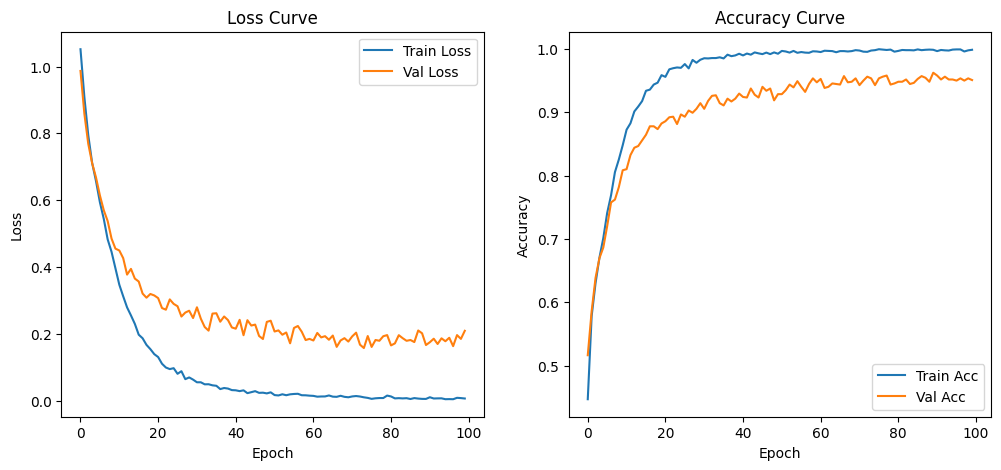

C:\Users\enine\AppData\Local\Temp\ipykernel_35656\615943614.py:290: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(r"L:\常惠林\code

Test Accuracy: 94.22%
混淆矩阵：
[[401  29   0]
 [ 32 330   3]
 [  0   1 328]]


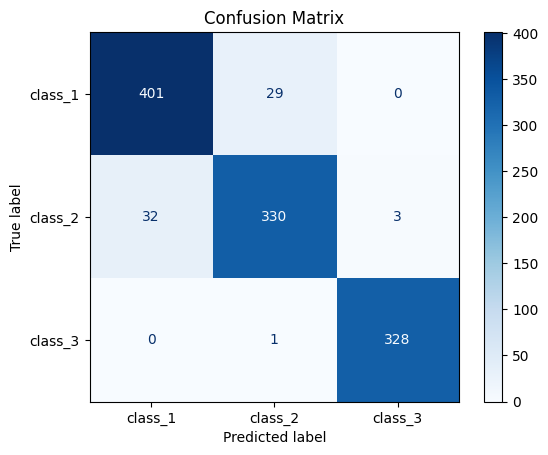

c:\Users\enine\anaconda3\envs\changhl\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
c:\Users\enine\anaconda3\envs\changhl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28176 (\N{CJK UNIFIED IDEOGRAPH-6E10}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\enine\anaconda3\envs\changhl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36827 (\N{CJK UNIFIED IDEOGRAPH-8FDB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\enine\anaconda3\envs\changhl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH

Grad-CAM 目标类别索引：0


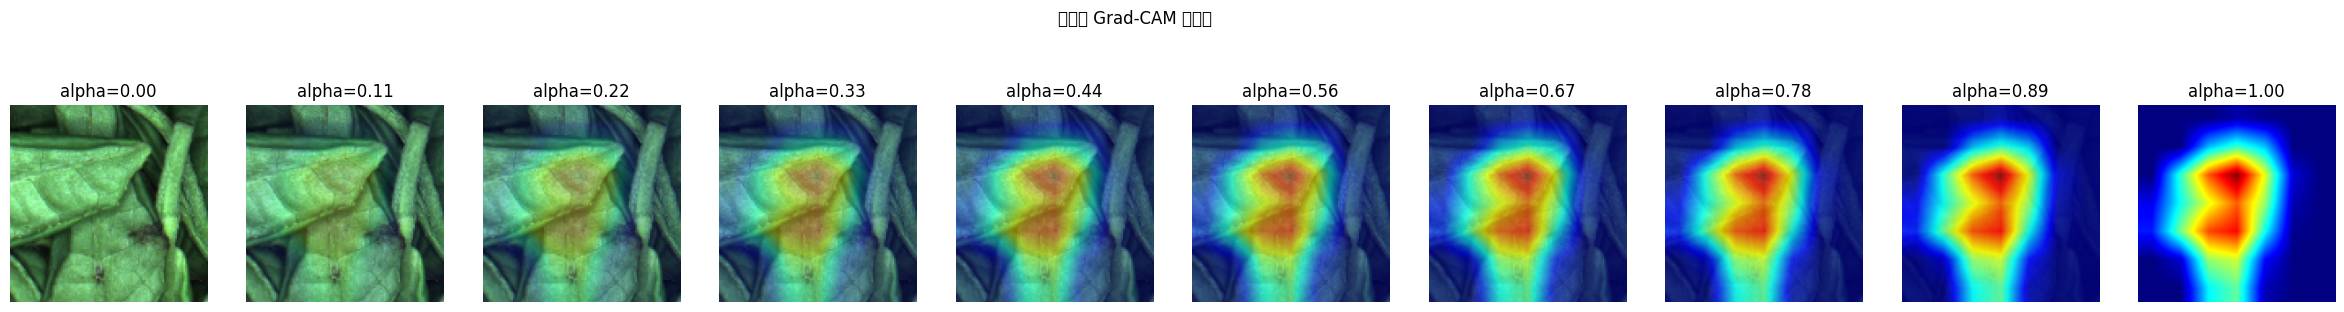

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import numpy as np

# 自定义数据集类：假定数据集目录下每个子文件夹对应一个类别
class EnhancedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # 按文件夹名称排序得到类别列表
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    img_path = os.path.join(cls_path, img_name)
                    images.append((img_path, self.class_to_idx[cls]))
        print(f"共加载 {len(images)} 张图片，共 {len(self.classes)} 个类别。")
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------------- Grad-CAM 实现 -------------------
class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: 训练好的模型
        target_layer: 需要观察的卷积层（例如 resnet50 的 layer4[-1]）
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_image, target_class=None):
        """
        input_image: Tensor, 尺寸为 [1, C, H, W]
        target_class: 指定类别索引；若为 None，则取模型预测类别
        返回：cam (numpy 数组，归一化到 [0,1]) 和 target_class
        """
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        # 获取梯度和特征图，尺寸为 [C, H', W']
        gradients = self.gradients[0]
        activations = self.activations[0]
        # 计算每个通道的重要性权重：对梯度在空间上求平均
        weights = torch.mean(gradients, dim=(1, 2))
        # 计算加权求和
        cam = torch.zeros(activations.shape[1:], dtype=activations.dtype, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        cam = torch.clamp(cam, min=0)  # 保留正值部分
        # 归一化
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        cam = cam.cpu().numpy()
        return cam, target_class

def show_gradcam_progressive(original_image, cam, steps=10):
    """
    original_image: PIL Image（RGB）
    cam: 归一化后的热力图（二维 numpy 数组，尺寸为 [H', W']）
    steps: 渐进展示的步数
    该函数会将 cam 缩放到原图尺寸，并依次叠加不同透明度的热力图展示
    """
    # 将原图转换为 numpy 数组（注意颜色空间为 RGB）
    img = np.array(original_image)
    # 调整 cam 尺寸到原图尺寸
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    # 应用 Jet 色图
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # cv2 默认 BGR 转换为 RGB
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    # 逐步增加热力图透明度
    alphas = np.linspace(0, 1, steps)
    overlays = []
    for alpha in alphas:
        overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
        overlays.append(overlay)

    # 使用 matplotlib 展示
    fig, axes = plt.subplots(1, steps, figsize=(3*steps, 4))
    for i, ax in enumerate(axes):
        ax.imshow(overlays[i])
        ax.axis('off')
        ax.set_title(f'alpha={alphas[i]:.2f}')
    plt.suptitle("渐进式 Grad-CAM 热力图")
    plt.show()

def generate_and_show_gradcam(model, dataset, test_subset, device, sample_idx=0):
    """
    从测试子集（random_split 后的 Subset 对象）中选取一张图片，
    利用 Grad-CAM 可视化该图片对模型的响应。
    sample_idx: 在测试子集中的索引（默认为 0）
    """
    # 获取原始数据集中对应的索引，并提取图片路径和标签
    original_idx = test_subset.indices[sample_idx]
    img_path, label = dataset.images[original_idx]
    # 用 PIL 加载原图（不进行数据增强）
    original_image = Image.open(img_path).convert("RGB")
    
    # 定义用于 Grad-CAM 的预处理（仅调整尺寸，不做数据增强）
    gradcam_transform = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
    ])
    input_tensor = gradcam_transform(original_image).unsqueeze(0).to(device)

    # 选择 ResNet50 的最后一层卷积层作为目标层（layer4 的最后一个 block）
    target_layer = model.layer4[-1]
    grad_cam = GradCAM(model, target_layer)
    cam, target_class = grad_cam(input_tensor)
    grad_cam.remove_hooks()

    print(f"Grad-CAM 目标类别索引：{target_class}")
    # 为了显示效果，将原图也调整到 224x224
    original_resized = original_image.resize((224, 224))
    show_gradcam_progressive(original_resized, cam, steps=10)

# ---------------- 主训练及测试流程 -------------------
def train():
    # 判断是否可用 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备：{device}")

    # 数据预处理：调整图片大小为 224x224，并进行数据增强
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 增大尺寸
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
        transforms.ToTensor(),
        transforms.GaussianBlur(5),
        transforms.RandomHorizontalFlip(),
    ])

    # 加载数据集（请确认路径正确）
    dataset = EnhancedDataset(root_dir=r"L:\常惠林\萎凋\自然萎凋\分类", transform=transform)
    total_size = len(dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    print(f"训练集：{train_size}，验证集：{val_size}，测试集：{test_size}")

    # 创建数据加载器，设置 batch size 为 64
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    # 加载在 ImageNet 上预训练的 ResNet50 模型
    model = models.resnet50(pretrained=True)
    # 修改最后一层全连接层，适应数据集类别数
    num_classes = len(dataset.classes)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # 训练配置
    num_epochs = 100
    best_val_acc = 0.0

    # 用于记录训练与验证过程的指标
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total_train += labels.size(0)
        epoch_loss = running_loss / total_train
        epoch_acc = running_correct / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_correct += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss = val_running_loss / total_val
        val_acc = val_running_correct / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        save_dir = r"L:\常惠林\code\result"
        os.makedirs(save_dir, exist_ok=True)  # 如果目录不存在，则创建目录

        # 保存验证集上表现最好的模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = os.path.join(save_dir, "best2_resnet50.pth")
            torch.save(model.state_dict(), save_path)
            print(f"保存最佳模型到: {save_path}")

    # 绘制训练/验证曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

    # 测试阶段
    model.load_state_dict(torch.load(os.path.join(r"L:\常惠林\code\result", "best2_resnet50.pth"), map_location=device))
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 计算混淆矩阵并显示
    cm = confusion_matrix(all_labels, all_preds)
    print("混淆矩阵：")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # ---------------- Grad-CAM 可视化 ----------------
    # 从测试集（random_split 得到的 test_dataset）中选取一张图片进行 Grad-CAM 可视化
    generate_and_show_gradcam(model, dataset, test_dataset, device, sample_idx=0)

if __name__ == "__main__":
    train()
